In [1]:
import warnings
import pickle
warnings.simplefilter(action='ignore')

In [2]:
fig_save_path =  '/path_to_figures/'

In [3]:
def enrich_factors(gsets, factor_dict, background='hsapiens_gene_ensembl'):
    ''' 
    calculate gene set enrichment scores for gene sets in factor marker genes.
    gsets: 'dictionary containing gene set names (keys) and gene sets (values)'
    factor_dict: 'dictionary containing factor names (keys) and factor marker genes (values)
    background: 'background genes to use for gsea enrichr (accepts string for reference genome in gseapy or int for background gene number)
    ''' 
    import gseapy as gp
    gsets= all_gs

    enr_df_list = []
    enr_dict = {}

    for i,v in factor_dict.items():
        glist = list(v)
        print(glist)
        enr = gp.enrichr(gene_list=glist,
                     gene_sets=gsets,
                     background=background, # or the number of genes, e.g 20000
                     outdir=None,
                     verbose=True)
        enr.results['factor'] = len(enr.results)*[i]
        enr_df_list.append(enr.results)
        enr_dict[i] = enr
    enr_df = pd.concat(enr_df_list)

    return enr_df,enr_dict

In [4]:
def compare_factors(df, data_column, matching_variable, comparison_variable, comparison_levels,test='wilcoxon',
                         zero_method='wilcox', correction=False, 
                          alternative='two-sided',  axis=0, 
                          nan_policy='propagate'):
    '''
    compute wilcoxon matched pairs signed rank on pandas dataframe
    df: pandas.DataFrame e.g. containing aggregated data_columns per patient
    data_column: column name storing the data to be compared
    matching_variable: column name in dataframe where categorical variable for matching is stored e.g. patient
    comparison_variable: column name in dataframe where variable to be compared is stored
    comparison_levels: list containing 2 levels of comparison variable to be compared
    variables from scipy.stats.wilcoxon: zero_method='wilcox', correction=False, alternative='two-sided',  axis=0, 
    nan_policy='propagate'
    '''
    from scipy.stats import wilcoxon
    import scipy
    df_pre = df[df[comparison_variable]==comparison_levels[0]].set_index(matching_variable).dropna(axis=0)
    df_on = df[df[comparison_variable]==comparison_levels[1]].set_index(matching_variable).dropna(axis=0)
    shared_patients = set(df_on.index).intersection(set(df_pre.index))
    
    if test=='wilcoxon':
        df_pre = df_pre.reindex(shared_patients)
        df_on = df_on.reindex(shared_patients)
        print('pre and on patients identical',list(df_pre.index)==list(df_on.index))
    a = df_pre[data_column]
    b= df_on[data_column]
    if test=='wilcoxon':
        result =  wilcoxon(a, b, zero_method=zero_method, correction=correction, 
                         alternative=alternative,  axis=axis, 
                         nan_policy=nan_policy)
    elif test=='mann-whitney':
        result = scipy.stats.mannwhitneyu(a,b, use_continuity=True, 
                                          alternative='two-sided', axis=0, method='auto',
                                          nan_policy='propagate',)
    return result



In [5]:
def aggregate_cell_scores(adata,clinical_var_obs,clinical_var2_obs,factor_name_list_corr,batch_key,patient_obs,
                            obs_columns,
                            zero_cutoff =0.001):
    '''
    aggregate factor cell scores per batch/patient:
    clinical_var_obs: for later fold change calculation --> #obs for clinical variable to calculate fold change over
    clinical_var2_obs #additional clinical variable
    patient_obs #key for patient id in adata.obs 
    batch_key #key for batch / sample in adata.obs
    factor_name_list_corr #list with factors to calculate fold change for
    zero_cutoff #mean of positive fraction per factor will be calculated, define threshold for positive frac if None mean without any cutoff will be calculated 
     obs_columns: name for columns in output dataframe (order will be clinical_var_obs, clinical_var2_obs, partient_obs)
    '''
    #first calculate mean of positive fraction for each sample
    df_batches = pd.DataFrame()

    for j in set(adata.obs[batch_key]):
        adata_subset = adata[adata.obs[batch_key]==j]
        clinical_var = list(set(adata_subset.obs[clinical_var_obs]))[0]
        clinical_var2 = list(set(adata_subset.obs[clinical_var2_obs]))[0]
        patient = list(set(adata_subset.obs[patient_obs]))[0]

        #define here which metric you want to use
        for i in factor_name_list_corr:
            if zero_cutoff == None:
                a = np.mean(adata_subset.obs[i])
            else:
                a = np.mean(adata_subset.obs[adata_subset.obs[i] >zero_cutoff][i])
            #a = np.mean(adata_CD8_pre.obs[i])

            df_batches.loc[j,i]=a
            df_batches.loc[j,obs_columns[0]] = clinical_var
            df_batches.loc[j,obs_columns[1]] = clinical_var2
            df_batches.loc[j,obs_columns[2]] = patient
    

    return df_batches

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
import scipy

In [7]:
def randomize_cells(anndata_object):
    "Randomize cells for plotting "
    index_list = np.arange(anndata_object.shape[0])
    np.random.shuffle(index_list)
    anndata_object = anndata_object[index_list]
    return anndata_object

In [8]:
def draw_square_gate(df, plot, group_names, x_name, y_name, xminmax, yminmax, width=2, color='#000000',print_absolute=False):
    '''draw a gate in seaborn jointplot
    df: input dataframe for seaborn.jointplot
    group_names: name of group column in dataframe df to calculate percentages 
    x_name: name of x axis column in dataframe df
    y_name: name of y axis columns in dataframe df
    plot: jointplot object
    xminmax: tuple (start,end) of gate x axis
    yminmax: tuple (start,end) of gate y axis
    color: color of line
    print_absolute: print counts instead of %'''
    #calculate cells in gat
    groups = list(set(df[group_names]))
    n_allcells = len(df[group_names])
    n_groups = []
    group_name_list = []

    ## calculate cells in gat for all cells

    n_ingate = df[df[x_name]>xminmax[0]]
    n_ingate = n_ingate[n_ingate[x_name]<xminmax[1]]
    n_ingate = n_ingate[n_ingate[y_name]>yminmax[0]]
    n_ingate = n_ingate[n_ingate[y_name]<yminmax[1]]
    group_name_list.append('all')
    n_groups.append((n_allcells,len(n_ingate)))


    for i in groups:
        group_name_list.append(i)
        group_df = df[df[group_names]==i]
        n_group = len(group_df)
        n_ingate = group_df[group_df[x_name]>xminmax[0]]
        n_ingate = n_ingate[n_ingate[x_name]<xminmax[1]]
        n_ingate = n_ingate[n_ingate[y_name]>yminmax[0]]
        n_ingate = n_ingate[n_ingate[y_name]<yminmax[1]]
        n_ingate = len(n_ingate)
        n_groups.append((n_group,n_ingate))
    
    #add gate
    plot.ax_joint.plot((xminmax[0], xminmax[0]),(yminmax[0], yminmax[1]),linewidth=width, color=color)
    plot.ax_joint.plot((xminmax[1], xminmax[1]),(yminmax[0], yminmax[1]),linewidth=width, color=color)
    plot.ax_joint.plot((xminmax[0], xminmax[1]),(yminmax[1], yminmax[1]),linewidth=width, color=color)
    plot.ax_joint.plot((xminmax[0], xminmax[1]),(yminmax[0], yminmax[0]),linewidth=width, color=color)
    
    title = []
    for i,v in enumerate(group_name_list):
        title.append(v+'_:_'+(str((n_groups[i][1]/n_groups[i][0])*100))+'%')
    print(title)
    
    return plot

In [9]:
import scanpy as sc

import numpy as np
import pandas as pd

#set params
sc.set_figure_params(frameon=False)
sc.set_figure_params(dpi=200)
sc.set_figure_params(figsize=(4, 4))


In [10]:
import torch
import scarches as sca
import gdown
torch.set_printoptions(precision=3, sci_mode=False, edgeitems=7)

ModuleNotFoundError: No module named 'torch'

In [ ]:
subtype_color_dict = {'global':'#FFFFFF','TAM':'#FFFF00',
                 'DC_cDC2A':'#1CE6FF',
                 'pDC':'#FF34FF',
                 'M-MDC':'#FF4A46',
                 'mono_c':'#008941',
                 'mast':'#006FA6',
                      'TAM_TRMac':'#456D75',
                 'DC_cDC1':'#A30059',
                 'Gr-MDC':'#7A4900',
                 'DC_Langerhans':'#0000A6',
                      'DC_AXLpos_ITGAXpos':'#0CBD66',
                      'DC_FDC_PTPRCpos':'#EEC3FF',
                'DC_cDC3':'#63FFAC',
                'CD8_T':'#B79762',
                'Treg':'#004D43',
                'CD4_T':'#8FB0FF',
                'CD8_T':'#997D87',
                 'NK':'#5A0007',
                 'gdT':'#809693',
                    'ILC3':'#7900D7',
                       'CD8_T_KLRG1pos_effector_preexhausted':'#4FC601',
                 'CD4_T_naive':'#3B5DFF',
                 'CD4_T_TH1':'#4A3B53',
                 'CD8_T_TRM':'#FF2F80',
                'CD8_T_TRM_exhausted':'#61615A',
                 'CD8_T_naive':'#BA0900',
                 'CD8_T_KLRG1pos_effector_preexhausted':'#6B7900',
             'CD4_T_naive_low_libsize':'#00C2A0',
                 'CD8_T_naive':'#FFAA92',
             'NK_CD56bright':'#FF90C9',
                 'CD8_T_TEM_effector_exhausted-progenitor':'#B903AA',
            'gdT':'#D16100',
              'CD8_T_KLRG1pos_effector_nonexhausted':'#DDEFFF',
              'CD8_T_TRM_exhausted_proliferating':'#000035',
            'CD4_T_TH1_proliferating':'#7B4F4B',
               'NK_CD56dim':'#A1C299',
               'Treg':'#300018',
                  'CD8_T_KLRG1pos_effector_preexhausted':'#0AA6D8',
                         'MDC':'#013349',
                 'DC':'#00846F',
                'mixed_T_M':'#636375',
                        'B_memory':'#372101',
                
                 'B_naive':'#FFB500',
                'plasma':'#C2FFED',
                'B_GC':'#A079BF',
                    'B_memory_switched':'#CC0744',
                'plasma_IgA':'#C0B9B2',
                 'B_memory_double_neg':'#C2FF99',
               'plasma_IgG':'#001E09',
                'plasmablast':'#00489C',
               'plasma_Be1':'#6F0062',
                     'M':'#B77B68',
                     'TNK':'#7A87A1',
                     'B':'#788D66',
                     'TAM_MKlike':'#885578',
                     'mono':'#34362D',
                     'mono_c':'#B4A8BD',
                     'mono_nc':'#00A6AA',
                     'ILC1':'#452C2C',
                     'CD4_T_TFH':'#A3C8C9',
                     'CD4_T_TFH_exhausted-progenitor':'#FF913F',
                     'CD4_T_TSCM':'#938A81',
                     'CD8_T_KLRG1neg_effector_preexhausted':'#575329',
                     'CD8_T_KLRG1pos_effector_exhausted':'#00FECF',
                     'CD8_T_TRM_nonexhausted':'#B05B6F',
                     'CD8_T_innate-like':'#8CD0FF',
                     'TNK_proliferating':'#3B9700',
                     'NK_CD56dim_proliferating':'#04F757',
                     'T':'#C8A1A1',
                     'T_proliferating':'#1E6E00',
                     'B_memory':"#BC23FF",
                      'B_naive':"#A77500",
                      'plasma':"#6367A9",
                 'B_GC':"#A05837",
                      'B_memory_switched':"#6B002C",
                 'B_naive':"#772600",
              'plasma_IgA':"#D790FF",
                'B_memory_double_neg':"#9B9700",
               'plasma_IgG':"#549E79",
                 'plasmablast':"#FFF69F",
                'plasma_IgG':"#201625",
                 'plasma_Be1':"#72418F",
                      'B':"#922329", 
                      'TNK':"#99ADC0",
                      'M': "#3A2465",
                      'nan':'#000000',
                      'B_GC_proliferating':'#5B4534',
                      'B_memory_switched_Be1':'#FDE8DC',
                      'B_memory_switched_proliferating':'#404E55',
                      'plasma_IgG_Be1':'#0089A3',
                       'B_proliferating':'#CB7E98'
                }

timepoint_dict = {'Pre':'#0E518F','On': '#DF480F','nan':'#dedede'}


In [ ]:
color_map_clusters_nogrey = ["#FFFF00", "#1CE6FF", "#FF34FF", "#FF4A46", "#008941", "#006FA6", "#A30059", "#7A4900", "#0000A6", "#63FFAC", "#B79762", "#004D43", "#8FB0FF", "#997D87",
"#5A0007", "#809693", "#1B4400", "#4FC601", "#3B5DFF", "#4A3B53", "#FF2F80",
"#61615A", "#BA0900", "#6B7900", "#00C2A0", "#FFAA92", "#FF90C9", "#B903AA", "#D16100",
"#DDEFFF", "#000035", "#7B4F4B", "#A1C299", "#300018", "#0AA6D8", "#013349", "#00846F",
"#372101", "#FFB500", "#C2FFED", "#A079BF", "#CC0744", "#C0B9B2", "#C2FF99", "#001E09",
"#00489C", "#6F0062", "#0CBD66", "#EEC3FF", "#456D75", "#B77B68", "#7A87A1", "#788D66",
"#885578", "#FAD09F", "#FF8A9A", "#D157A0", "#BEC459", "#456648", "#0086ED", "#886F4C",
"#34362D", "#B4A8BD", "#00A6AA", "#452C2C", "#636375", "#A3C8C9", "#FF913F", "#938A81",
"#575329", "#00FECF", "#B05B6F", "#8CD0FF", "#3B9700", "#04F757", "#C8A1A1", "#1E6E00",
"#7900D7", "#A77500", "#6367A9", "#A05837", "#6B002C", "#772600", "#D790FF", "#9B9700",
"#549E79", "#FFF69F", "#201625", "#72418F", "#BC23FF", "#99ADC0", "#3A2465", "#922329",
"#5B4534", "#FDE8DC", "#404E55", "#0089A3", "#CB7E98", "#A4E804", "#324E72", "#6A3A4C"]

In [ ]:
!conda list

# get Spectra dictionary

In [ ]:
#install from here: https://github.com/wallet-maker/cytopus
import cytopus as cp

In [ ]:
G = cp.kb.KnowledgeBase()

In [ ]:
gs_df = cp.tl.get_gmt(G.processes)
gs_df

In [18]:
#save as gmt
gs_df.to_csv('Spectra_dict_new.gmt',sep='\t')

# Create expimap (no soft mask, all default settings)

## get data

In [67]:
working_dir ='/path_to_data/'

In [68]:
adata_path = working_dir + 'PBMC-X-NA-X-Kartha-X-scRNAseq-X-10.1016_j.xgen.2022.100166_normalized_clustered_10000hv_batch_annotated_noribo_nomito.h5ad'

adata_save_path_1 = working_dir + 'PBMC-X-NA-X-Kartha-X-scRNAseq-X-10.1016_j.xgen.2022.100166_normalized_clustered_10000hv_batch_annotated_noribo_nomito_alldefault_new.h5ad'
model_save_path_1 = working_dir + 'PBMC-X-NA-X-Kartha-X-scRNAseq-X-10.1016_j.xgen.2022.100166_normalized_clustered_10000hv_batch_annotated_noribo_nomito_alldefault_nonewnodes_new.pickle'


In [69]:
#read adata
adata = sc.read(adata_path)
adata

Only considering the two last: ['.100166_normalized_clustered_10000hv_batch_annotated_noribo_nomito', '.h5ad'].
Only considering the two last: ['.100166_normalized_clustered_10000hv_batch_annotated_noribo_nomito', '.h5ad'].


AnnData object with n_obs × n_vars = 23754 × 19004
    obs: 'nCount_RNA', 'nFeature_RNA', 'Condition', 'StimType', 'Donor', 'pheno_k10', 'pheno_k20', 'pheno_k30', 'pheno_k40', 'pheno_k50', 'pheno_k60', 'pheno_k70', 'pheno_k80', 'pheno_k90', 'pheno_k100', 'pheno_var_k10', 'pheno_var_k20', 'pheno_var_k30', 'pheno_var_k40', 'pheno_var_k50', 'pheno_var_k60', 'pheno_var_k70', 'pheno_var_k80', 'pheno_var_k90', 'pheno_var_k100', 'annotation'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'annotation_colors', 'hvg', 'log1p', 'neighbors', 'pca', 'pheno_var_k40_colors', 'tsne', 'umap'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    layers: 'imputed', 'raw'
    obsp: 'connectivities', 'distances'

In [70]:
adata

AnnData object with n_obs × n_vars = 23754 × 19004
    obs: 'nCount_RNA', 'nFeature_RNA', 'Condition', 'StimType', 'Donor', 'pheno_k10', 'pheno_k20', 'pheno_k30', 'pheno_k40', 'pheno_k50', 'pheno_k60', 'pheno_k70', 'pheno_k80', 'pheno_k90', 'pheno_k100', 'pheno_var_k10', 'pheno_var_k20', 'pheno_var_k30', 'pheno_var_k40', 'pheno_var_k50', 'pheno_var_k60', 'pheno_var_k70', 'pheno_var_k80', 'pheno_var_k90', 'pheno_var_k100', 'annotation'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'annotation_colors', 'hvg', 'log1p', 'neighbors', 'pca', 'pheno_var_k40_colors', 'tsne', 'umap'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    layers: 'imputed', 'raw'
    obsp: 'connectivities', 'distances'

In [71]:
#set adata.X to raw
adata.X = adata.raw[adata.obs_names,adata.var_names].X

In [72]:
print(adata.X)

  (0, 2550)	1.0
  (0, 3929)	1.0
  (0, 11531)	9.0
  (0, 14297)	1.0
  (0, 15207)	6.0
  (0, 15072)	1.0
  (0, 18423)	2.0
  (0, 10247)	1.0
  (0, 11976)	2.0
  (0, 2284)	1.0
  (0, 13717)	1.0
  (0, 175)	1.0
  (0, 8313)	2.0
  (0, 12187)	3.0
  (0, 10324)	2.0
  (0, 10166)	2.0
  (0, 12386)	16.0
  (0, 2389)	4.0
  (0, 16300)	1.0
  (0, 16728)	1.0
  (0, 17707)	2.0
  (0, 18950)	1.0
  (0, 12794)	1.0
  (0, 5738)	3.0
  (0, 13473)	3.0
  :	:
  (23753, 11450)	5.0
  (23753, 10039)	2.0
  (23753, 14566)	2.0
  (23753, 8952)	1.0
  (23753, 4457)	3.0
  (23753, 10458)	1.0
  (23753, 16160)	1.0
  (23753, 7289)	1.0
  (23753, 18282)	1.0
  (23753, 1815)	1.0
  (23753, 505)	2.0
  (23753, 16369)	1.0
  (23753, 18317)	1.0
  (23753, 95)	1.0
  (23753, 13444)	1.0
  (23753, 17557)	1.0
  (23753, 7571)	2.0
  (23753, 8416)	1.0
  (23753, 12391)	1.0
  (23753, 1483)	2.0
  (23753, 13080)	1.0
  (23753, 4052)	4.0
  (23753, 12961)	4.0
  (23753, 9683)	2.0
  (23753, 16347)	1.0


In [73]:
#Remove all genes which are not present in the annotations.
sca.utils.add_annotations(adata, 'Spectra_dict_new.gmt', min_genes=12, clean=False, genes_use_upper=False)

In [74]:
adata._inplace_subset_var(adata.varm['I'].sum(1)>0)

In [75]:
sc.pp.normalize_total(adata)

In [76]:
sc.pp.log1p(adata)

In [77]:
adata

AnnData object with n_obs × n_vars = 23754 × 4626
    obs: 'nCount_RNA', 'nFeature_RNA', 'Condition', 'StimType', 'Donor', 'pheno_k10', 'pheno_k20', 'pheno_k30', 'pheno_k40', 'pheno_k50', 'pheno_k60', 'pheno_k70', 'pheno_k80', 'pheno_k90', 'pheno_k100', 'pheno_var_k10', 'pheno_var_k20', 'pheno_var_k30', 'pheno_var_k40', 'pheno_var_k50', 'pheno_var_k60', 'pheno_var_k70', 'pheno_var_k80', 'pheno_var_k90', 'pheno_var_k100', 'annotation'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'annotation_colors', 'hvg', 'log1p', 'neighbors', 'pca', 'pheno_var_k40_colors', 'tsne', 'umap', 'terms'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs', 'I'
    layers: 'imputed', 'raw'
    obsp: 'connectivities', 'distances'

In [78]:
torch.cuda.is_available()

True

In [79]:
#we also tried running this with 4000 hv genes which did not improve the results
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=2000,
    batch_key="Donor",
    subset=True)

In [80]:
#we also deviate from the expiMap tutorial here to include smaller gene sets because it was performing worse
#with the standard setting e.g. removing the tumor reactivity gene set entirely which was smaller than 12 genes
select_terms = adata.varm['I'].sum(0)>12

In [81]:
adata.uns['terms'] = np.array(adata.uns['terms'])[select_terms].tolist()

In [82]:
set(adata.uns['terms'])

{'B_CD40L_response',
 'B_IgM-ligation_response',
 'CD8-T_IL12_response',
 'DC_CD40L_response',
 'DC_LPS_response',
 'M_angiogenic-effectors',
 'M_gran_CSF2_response',
 'M_mac_CSF1_response',
 'Mac_LPS-IFNG_invitro_response',
 'Mac_LPS_response',
 'NK_IL15_response',
 'TNK_IL2-STAT5-signaling',
 'T_tcr-activation',
 'all_DNA-repair',
 'all_GPI-anchor_synthesis',
 'all_IL6-JAK-STAT3_signaling',
 'all_JAK-STAT_signaling',
 'all_MHC-II-presentation',
 'all_MYC_targets',
 'all_NOD-like-receptor_signaling',
 'all_NOTCH_signaling',
 'all_PI3K-AKT-mTOR_signaling',
 'all_RIG-I-like-receptor_signaling',
 'all_SASP',
 'all_TLR_signaling',
 'all_TNF-via-NFkB_signaling',
 'all_VAL-LEU-ILE_metabolism',
 'all_actin-cytoskeleton_regulation',
 'all_apoptosis',
 'all_autophagy-of-mitochondria',
 'all_autophagy-selective',
 'all_autophagy_regulation_positive',
 'all_cholesterol-homeostasis',
 'all_chondroitine-and-heparan-sulfate_synthesis',
 'all_citric-acid-cycle',
 'all_cytosolic-DNA-sensing_signaling

In [83]:
adata.varm['I'] = adata.varm['I'][:, select_terms]



In [84]:
adata._inplace_subset_var(adata.varm['I'].sum(1)>0)

In [85]:
#set adata.X to raw
adata.X = adata.raw[adata.obs_names,adata.var_names].X

In [86]:
adata

AnnData object with n_obs × n_vars = 23754 × 1841
    obs: 'nCount_RNA', 'nFeature_RNA', 'Condition', 'StimType', 'Donor', 'pheno_k10', 'pheno_k20', 'pheno_k30', 'pheno_k40', 'pheno_k50', 'pheno_k60', 'pheno_k70', 'pheno_k80', 'pheno_k90', 'pheno_k100', 'pheno_var_k10', 'pheno_var_k20', 'pheno_var_k30', 'pheno_var_k40', 'pheno_var_k50', 'pheno_var_k60', 'pheno_var_k70', 'pheno_var_k80', 'pheno_var_k90', 'pheno_var_k100', 'annotation'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches', 'dispersions', 'dispersions_norm', 'highly_variable_intersection'
    uns: 'annotation_colors', 'hvg', 'log1p', 'neighbors', 'pca', 'pheno_var_k40_colors', 'tsne', 'umap', 'terms'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs', 'I'
    layers: 'imputed', 'raw'
    obsp: 'connectivities', 'distances'

## fit model

In [87]:
#there was only one study in our data so we set a dummy variable (because it was not possible to run with None or False)
adata.obs['study'] = len(adata.obs)*['PBMC']

In [88]:
#we deviate from the tutorial here to let expiMap include new genes in the gene programs not only the genes in the gene sets
#because this is one property Spectra excels and we wanted to compare expiMap against it. We noticed that the specificity of the
#factors vs the ground truth perturbations was not better without the soft mask.
intr_cvae = sca.models.EXPIMAP(
    adata=adata,
    condition_key='study',
    hidden_layer_sizes=[256, 256, 256],
    recon_loss='nb'
)


INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 1841 256 1
	Hidden Layer 1 in/out: 256 256
	Hidden Layer 2 in/out: 256 256
	Mean/Var Layer in/out: 256 69
Decoder Architecture:
	Masked linear layer in, ext_m, ext, cond, out:  69 0 0 1 1841
	with hard mask.
Last Decoder layer: softmax


In [89]:
#strength of group lasso regularization
ALPHA = 0.7  #standard param from tutorial

In [90]:
early_stopping_kwargs = {
    "early_stopping_metric": "val_unweighted_loss", # val_unweighted_loss
    "threshold": 0,
    "patience": 50,
    "reduce_lr": True,
    "lr_patience": 13,
    "lr_factor": 0.1,
}
intr_cvae.train(
    n_epochs=400,  #standard param from tutorial
    alpha_epoch_anneal=100,  #standard param from tutorial
    alpha=ALPHA,  #standard param from tutorial
    alpha_kl=0.5,  #standard param from tutorial
    weight_decay=0.,  #standard param from tutorial
    early_stopping_kwargs=early_stopping_kwargs,
    use_early_stopping=True,  #standard param from tutorial
    monitor_only_val=False,  #standard param from tutorial
    seed=2020,
)



Init the group lasso proximal operator for the main terms.
 |███████-------------| 37.8%  - epoch_loss: 572.3686774118 - epoch_recon_loss: 555.3423908779 - epoch_kl_loss: 34.0525703317 - val_loss: 583.8184493215 - val_recon_loss: 567.0115292198 - val_kl_loss: 33.6138429140865
ADJUSTED LR
 |████████------------| 42.8%  - epoch_loss: 573.3229836963 - epoch_recon_loss: 556.2391835167 - epoch_kl_loss: 34.1676007680 - val_loss: 584.0285259046 - val_recon_loss: 567.1740529914 - val_kl_loss: 33.7089257491
ADJUSTED LR
 |█████████-----------| 46.0%  - epoch_loss: 570.6543482826 - epoch_recon_loss: 553.6042700268 - epoch_kl_loss: 34.1001561483 - val_loss: 583.7601960835 - val_recon_loss: 566.9581298828 - val_kl_loss: 33.6041325017
ADJUSTED LR
 |█████████-----------| 49.2%  - epoch_loss: 571.3783273243 - epoch_recon_loss: 554.2805119469 - epoch_kl_loss: 34.1956292448 - val_loss: 583.5887483296 - val_recon_loss: 566.7570029811 - val_kl_loss: 33.6634872838
ADJUSTED LR
 |██████████----------| 52.0% 

In [91]:
import pickle
with open(model_save_path_1, 'wb') as f:
    pickle.dump(intr_cvae, f, pickle.HIGHEST_PROTOCOL)

In [92]:
with open(model_save_path_1, 'rb') as f:
    intr_cvae = pickle.load(f)

In [93]:
set(adata.uns['terms'])

{'B_CD40L_response',
 'B_IgM-ligation_response',
 'CD8-T_IL12_response',
 'DC_CD40L_response',
 'DC_LPS_response',
 'M_angiogenic-effectors',
 'M_gran_CSF2_response',
 'M_mac_CSF1_response',
 'Mac_LPS-IFNG_invitro_response',
 'Mac_LPS_response',
 'NK_IL15_response',
 'TNK_IL2-STAT5-signaling',
 'T_tcr-activation',
 'all_DNA-repair',
 'all_GPI-anchor_synthesis',
 'all_IL6-JAK-STAT3_signaling',
 'all_JAK-STAT_signaling',
 'all_MHC-II-presentation',
 'all_MYC_targets',
 'all_NOD-like-receptor_signaling',
 'all_NOTCH_signaling',
 'all_PI3K-AKT-mTOR_signaling',
 'all_RIG-I-like-receptor_signaling',
 'all_SASP',
 'all_TLR_signaling',
 'all_TNF-via-NFkB_signaling',
 'all_VAL-LEU-ILE_metabolism',
 'all_actin-cytoskeleton_regulation',
 'all_apoptosis',
 'all_autophagy-of-mitochondria',
 'all_autophagy-selective',
 'all_autophagy_regulation_positive',
 'all_cholesterol-homeostasis',
 'all_chondroitine-and-heparan-sulfate_synthesis',
 'all_citric-acid-cycle',
 'all_cytosolic-DNA-sensing_signaling

In [94]:
MEAN = False



In [95]:
adata.obsm['X_cvae'] = intr_cvae.get_latent(mean=MEAN, only_active=True)

In [96]:
sc.pp.neighbors(adata, use_rep='X_cvae')



In [97]:
sc.tl.umap(adata)

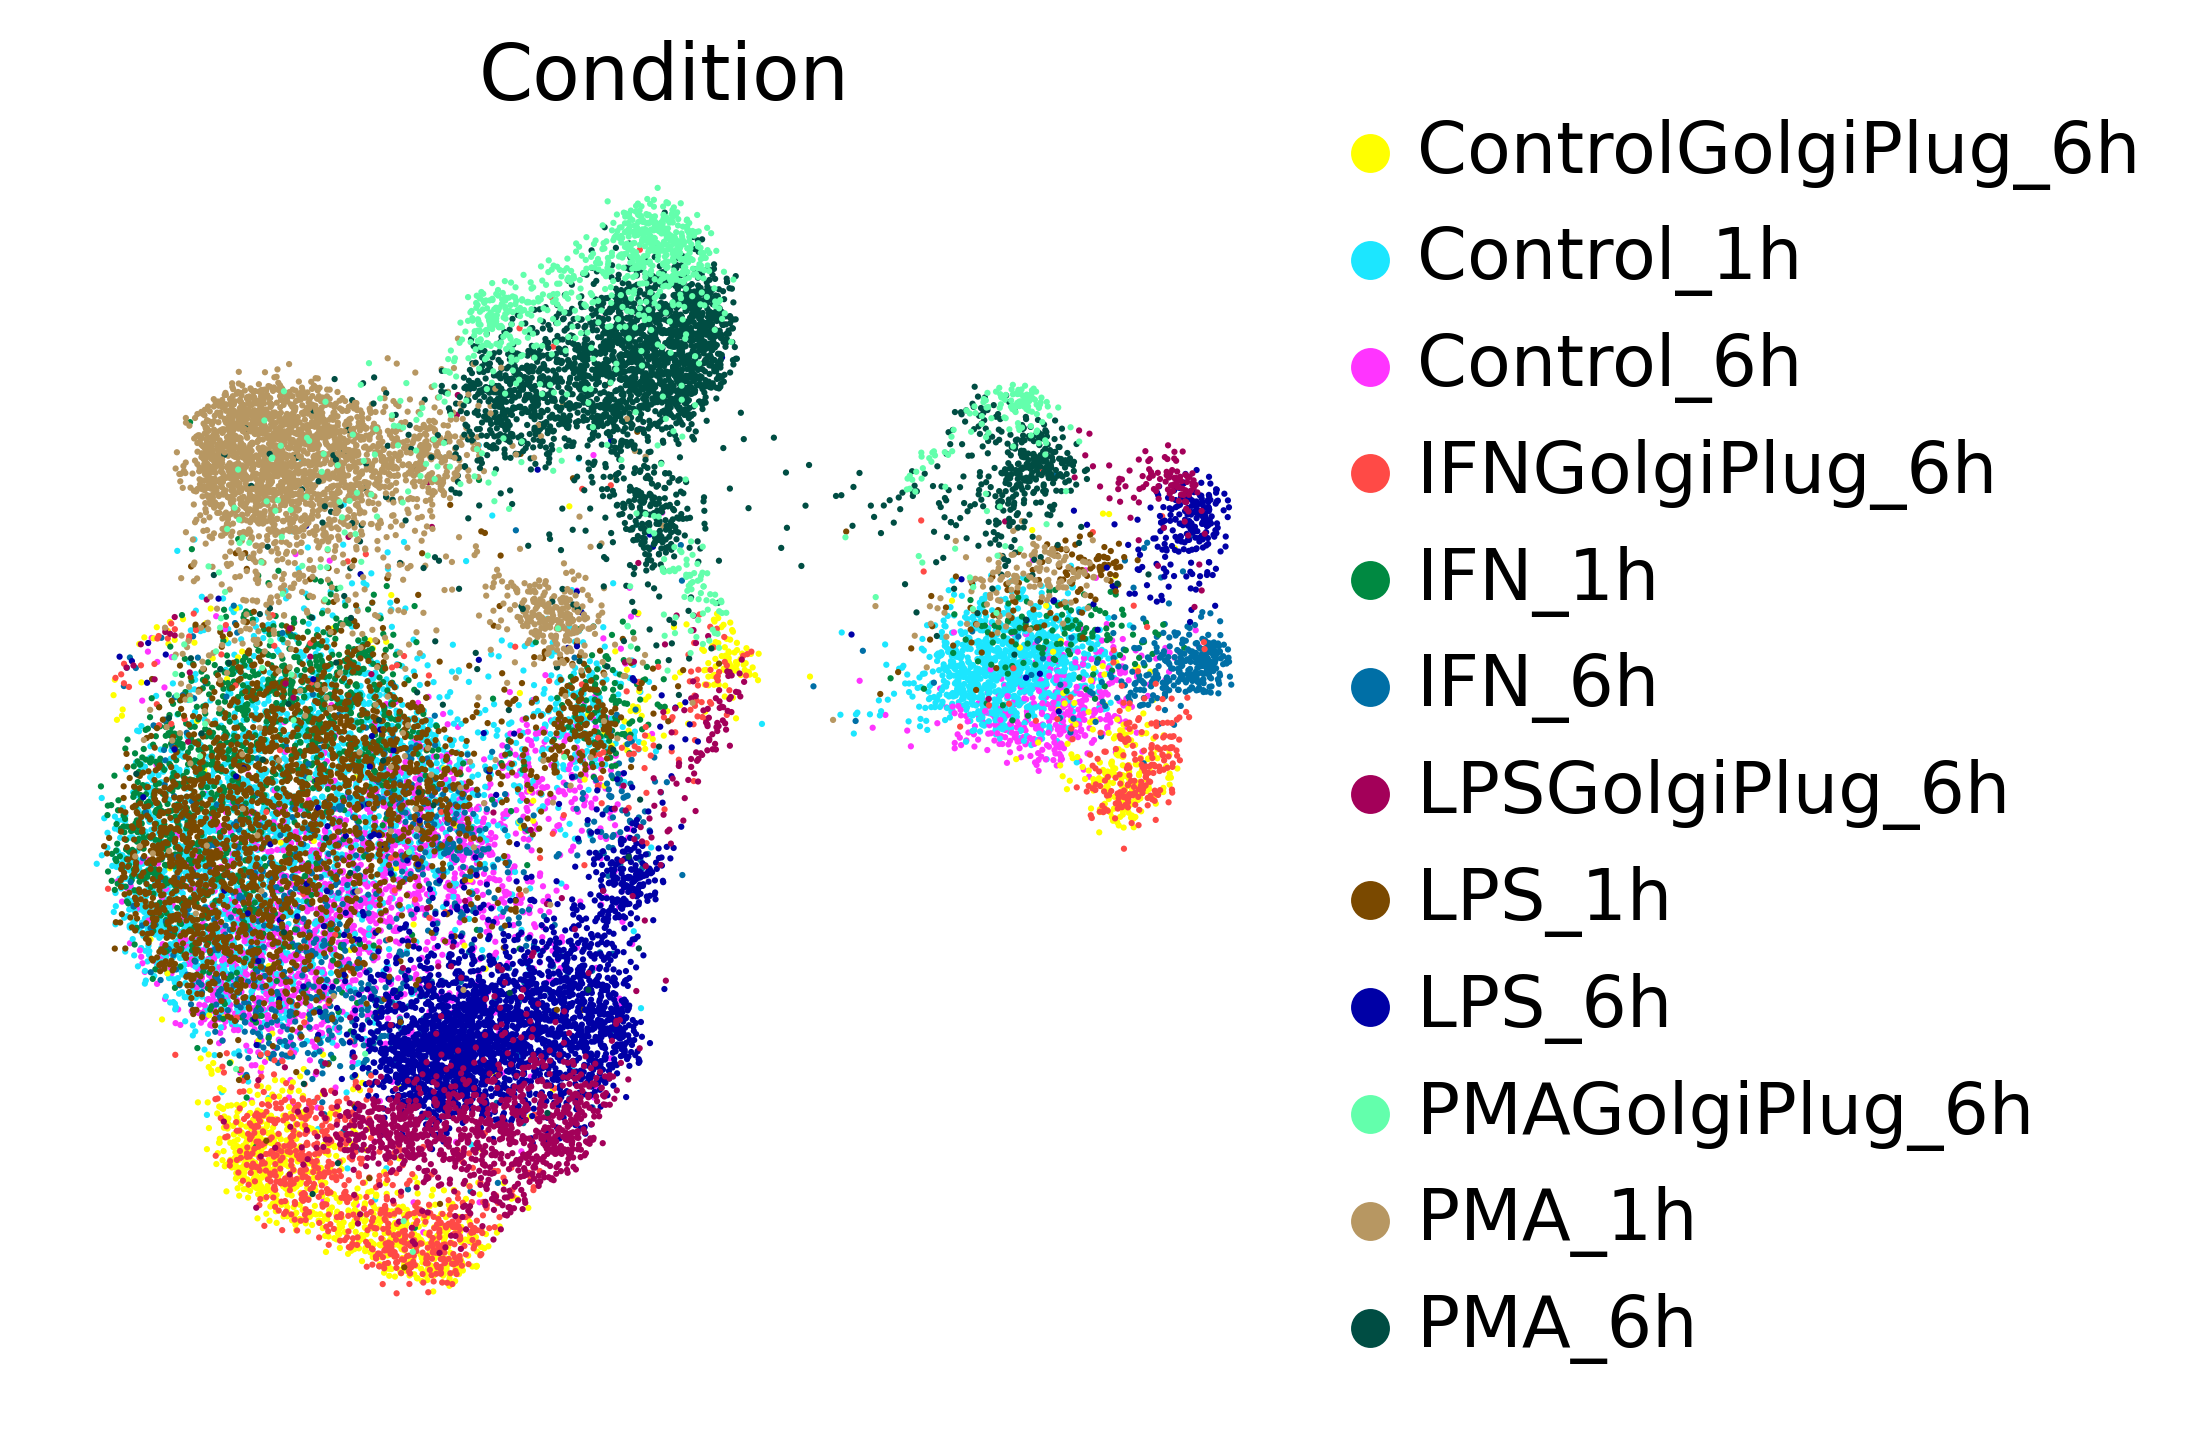

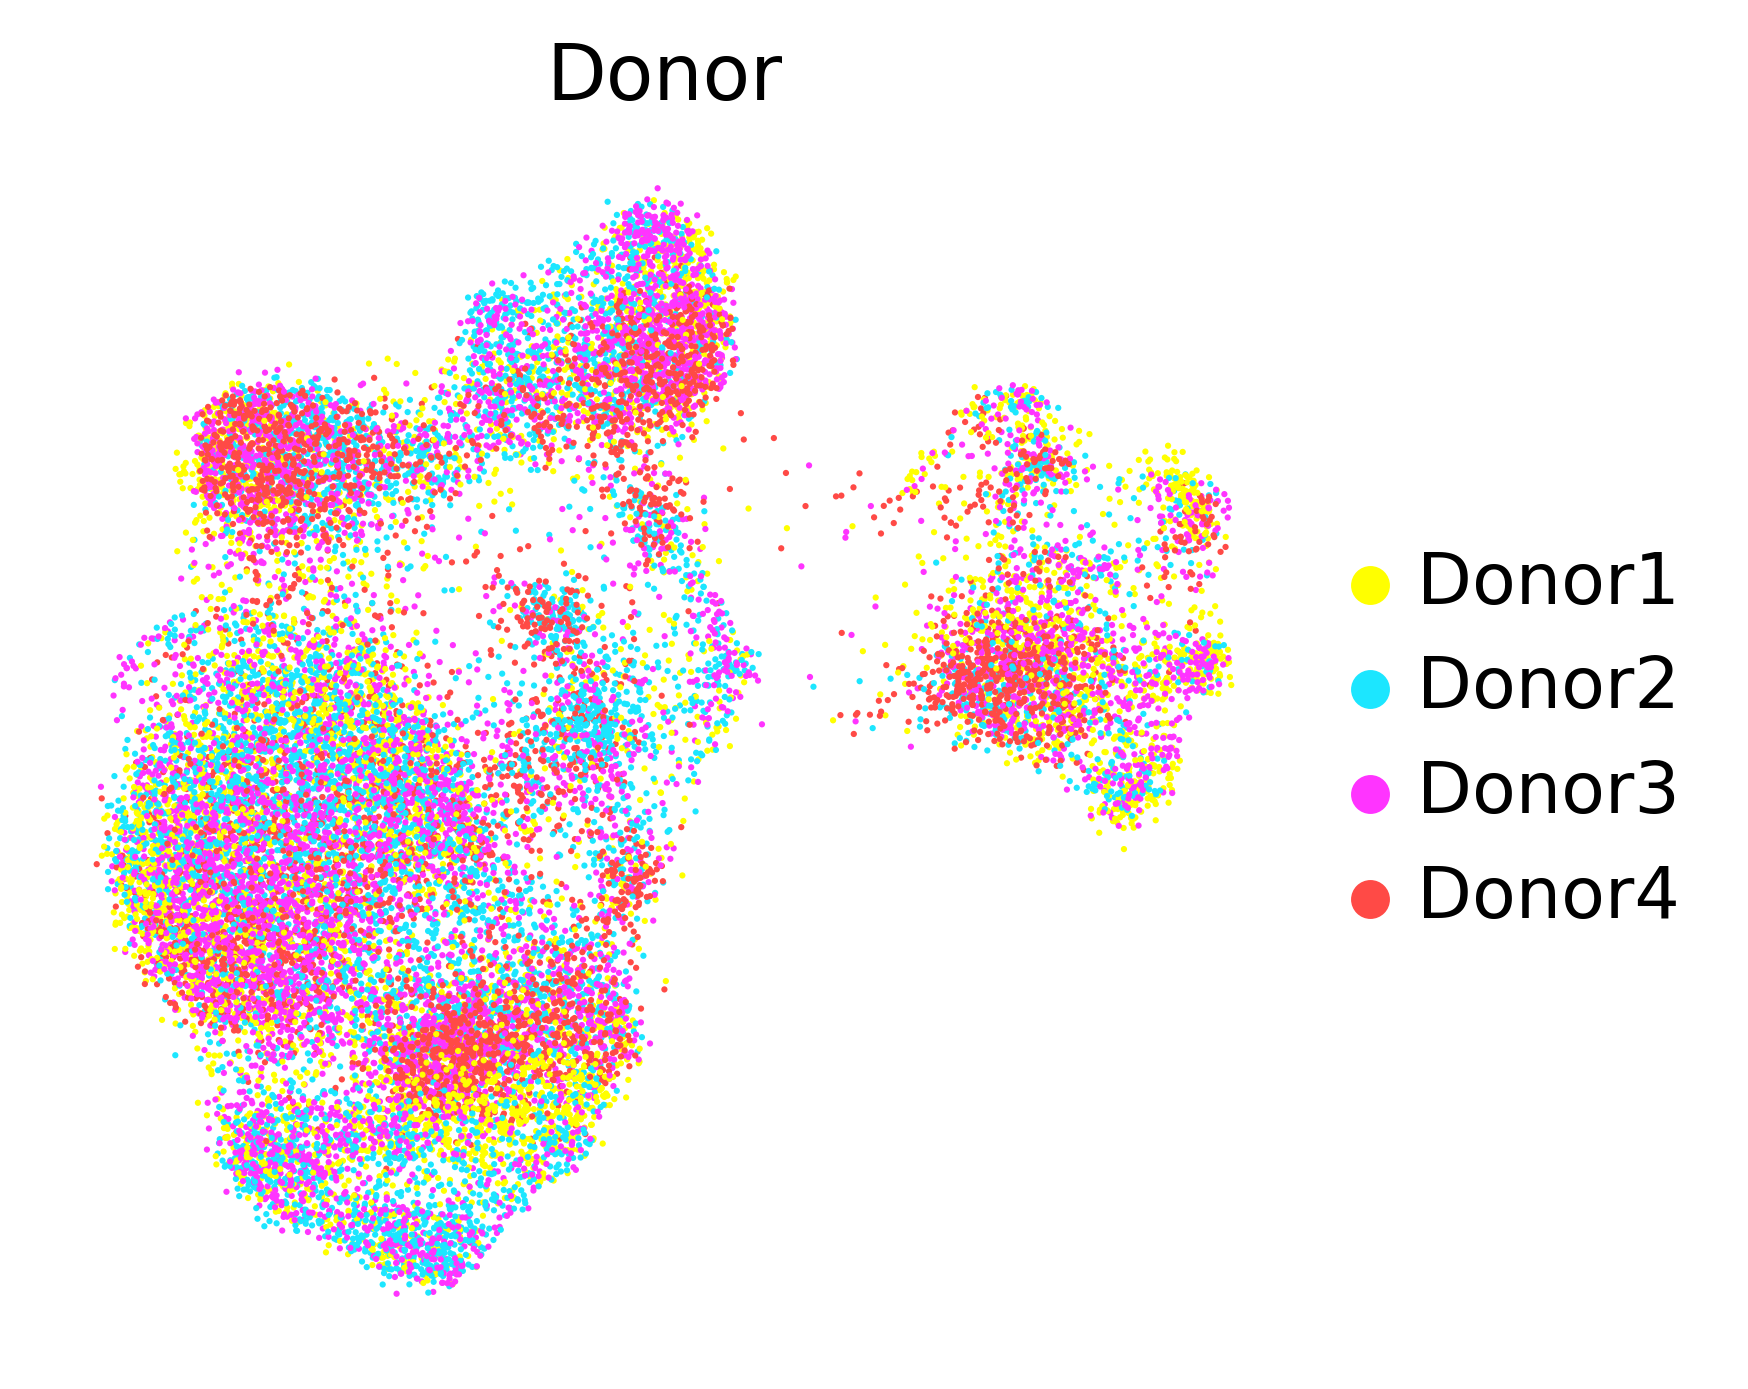

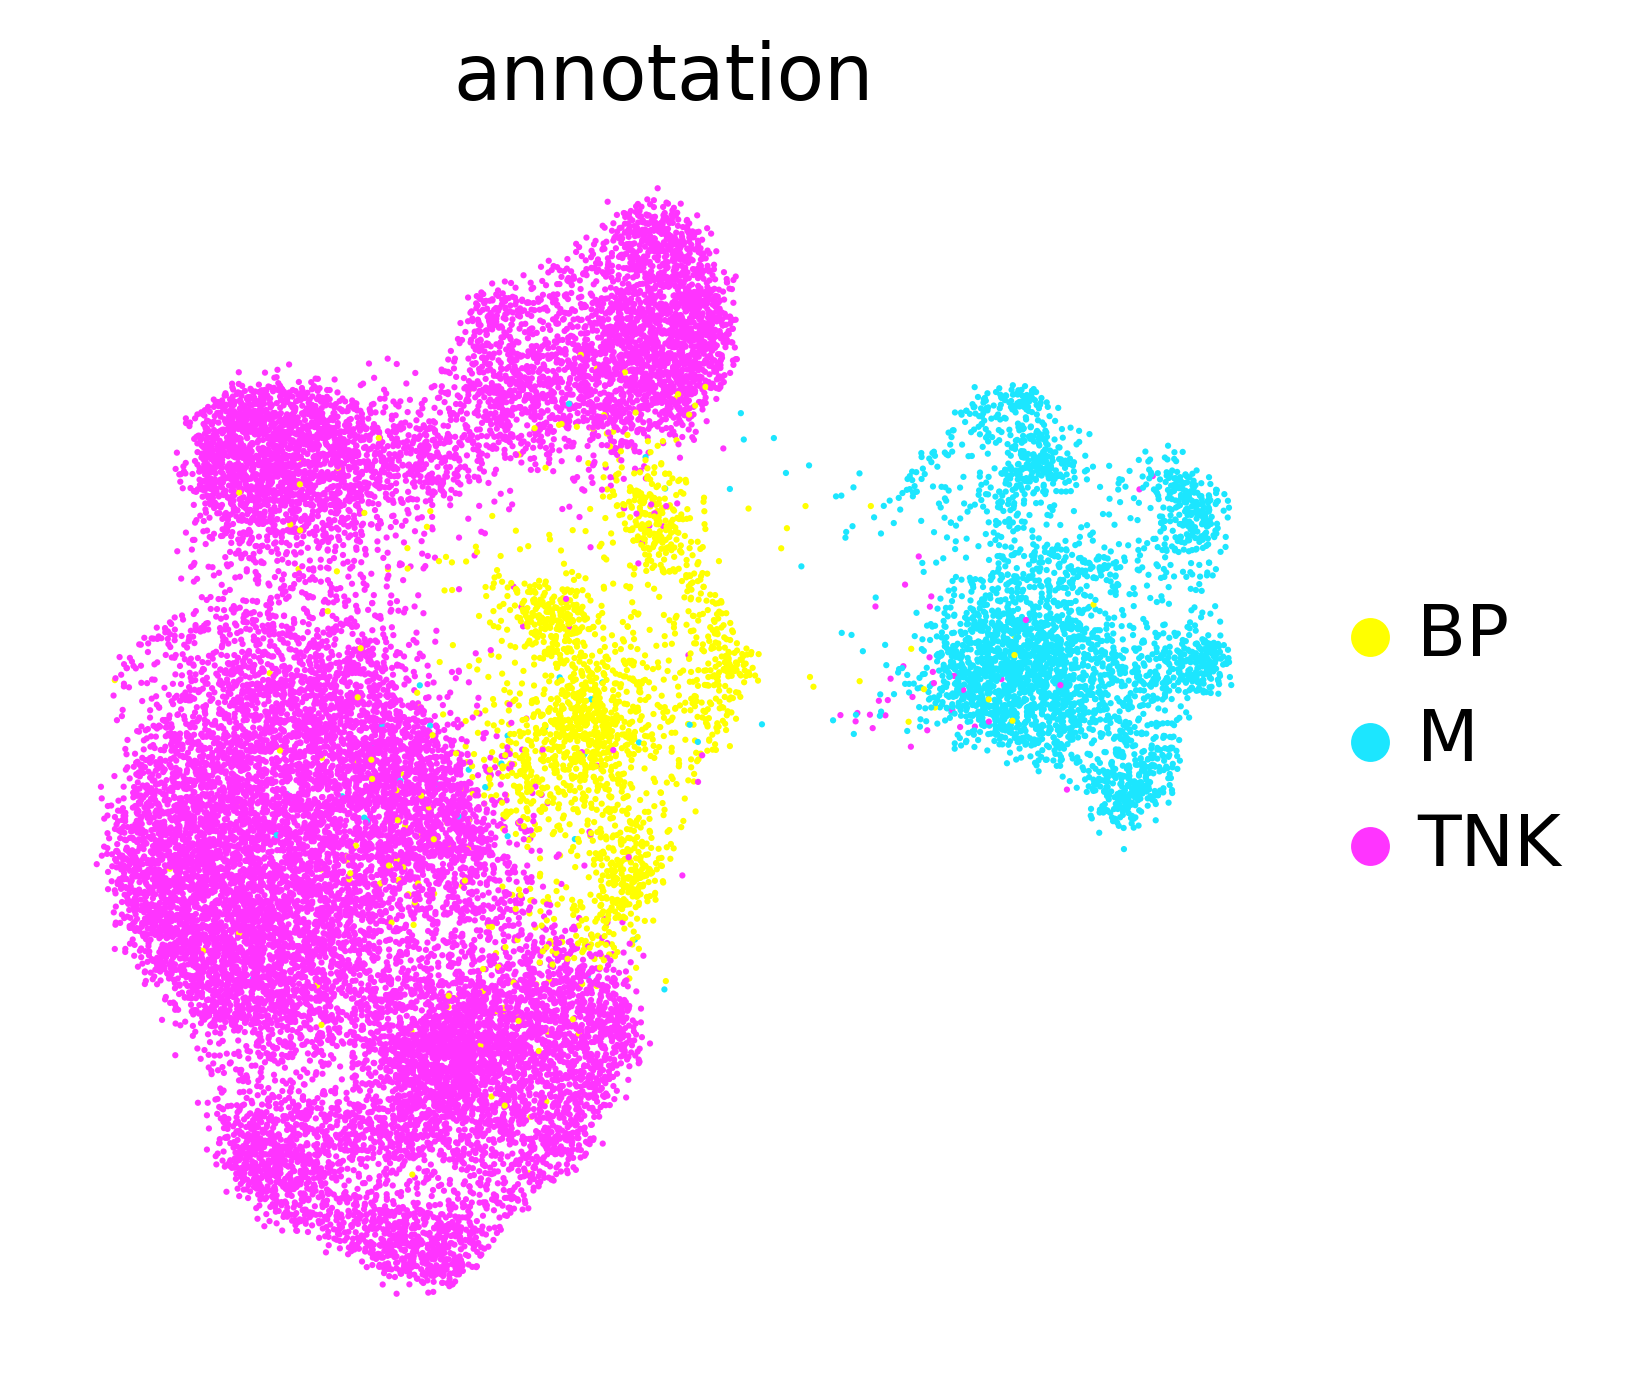

In [98]:
sc.pl.umap(adata, color=['Condition'], frameon=False,palette=color_map_clusters_nogrey)
sc.pl.umap(adata, color=['Donor'], frameon=False,palette=color_map_clusters_nogrey)

sc.pl.umap(adata, color=['annotation'], frameon=False,palette=color_map_clusters_nogrey)

In [99]:
adata.var_names

Index(['UBE2G1', 'KLHL11', 'E2F5', 'RRM2B', 'CDC14B', 'URB2', 'HLA-E',
       'IL1RL1', 'F13A1', 'EMC3',
       ...
       'ITGA2', 'GTF2H5', 'RNF121', 'SELP', 'PID1', 'VPS13D', 'FES', 'IGFBP3',
       'RAB33B', 'SYTL2'],
      dtype='object', name='genes', length=1841)

In [100]:
set(adata.uns['terms'])

{'B_CD40L_response',
 'B_IgM-ligation_response',
 'CD8-T_IL12_response',
 'DC_CD40L_response',
 'DC_LPS_response',
 'M_angiogenic-effectors',
 'M_gran_CSF2_response',
 'M_mac_CSF1_response',
 'Mac_LPS-IFNG_invitro_response',
 'Mac_LPS_response',
 'NK_IL15_response',
 'TNK_IL2-STAT5-signaling',
 'T_tcr-activation',
 'all_DNA-repair',
 'all_GPI-anchor_synthesis',
 'all_IL6-JAK-STAT3_signaling',
 'all_JAK-STAT_signaling',
 'all_MHC-II-presentation',
 'all_MYC_targets',
 'all_NOD-like-receptor_signaling',
 'all_NOTCH_signaling',
 'all_PI3K-AKT-mTOR_signaling',
 'all_RIG-I-like-receptor_signaling',
 'all_SASP',
 'all_TLR_signaling',
 'all_TNF-via-NFkB_signaling',
 'all_VAL-LEU-ILE_metabolism',
 'all_actin-cytoskeleton_regulation',
 'all_apoptosis',
 'all_autophagy-of-mitochondria',
 'all_autophagy-selective',
 'all_autophagy_regulation_positive',
 'all_cholesterol-homeostasis',
 'all_chondroitine-and-heparan-sulfate_synthesis',
 'all_citric-acid-cycle',
 'all_cytosolic-DNA-sensing_signaling

In [ ]:
adata.write(adata_save_path_1)
print('saved to:',adata_save_path_1)